In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
import time
sys.path.append('../../../src')

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import Normalizer

from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity, standardize
from common.default import PASSING_DEFAULT
from display.display import display
from individual_activity.individual_activity import IndividualActivity

In [2]:
device_idx = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'}
]

In [4]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = common.homo[room_num][0]
    p_field = common.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.76it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 20.17it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.00it/s]


# 特徴量抽出とデータ生成

In [7]:
def extract_features(frame_num, label1, label2, individuals):
    individual1 = individuals[label1]
    pos1 = individual1.get_data('position', frame_num)
    body1 = individual1.get_data('body_vector', frame_num)
    arm1 = individual1.get_data('arm_ext', frame_num)
    wrist1 = [
        individual1.get_keypoints('LWrist', frame_num),
        individual1.get_keypoints('RWrist', frame_num)
    ]
    if pos1 is None or body1 is None or arm1 is None or None in wrist1:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_data('position', frame_num)
    body2 = individual2.get_data('body_vector', frame_num)
    arm2 = individual2.get_data('arm_ext', frame_num)
    wrist2 = [
        individual2.get_keypoints('LWrist', frame_num),
        individual2.get_keypoints('RWrist', frame_num)
    ]
    if pos2 is None or body2 is None or arm2 is None or None in wrist2:
        return None
    
    # ポジション間の距離
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    # if norm < 50 or 300 < norm:
    #     # norm が範囲外の時はデータに加えない
    #     # plot.ipynb の分布から決定した
    #     return None
    
    distance_prob = gauss(
        norm,
        mu=PASSING_DEFAULT['gauss_mu'],
        sigma=PASSING_DEFAULT['gauss_sig'])
    
    # 体の向き
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)
    p1p2 = pos2 - pos1
    p2p1 = pos1 - pos2
    p1_sim = cos_similarity(body1, p1p2)
    p2_sim = cos_similarity(body2, p2p1)
    body_direction = (np.average([p1_sim, p2_sim]) + 1) / 2  # [-1, 1] -> [0, 1]
    
    # 腕の上げ下げ
    arm_ave = np.average([arm1, arm2])
    
    # 手首の距離
    min_norm = np.inf
    for i in range(2):
        for j in range(2):
            norm = np.linalg.norm(
                np.array(wrist1[i]) - np.array(wrist2[j]), ord=2)
            if norm < min_norm:
                min_norm = norm
    distance_prob_wrist = gauss(
        min_norm,
        mu=PASSING_DEFAULT['wrist_gauss_mu'],
        sigma=PASSING_DEFAULT['wrist_gauss_sig'])

    return [distance_prob, body_direction, arm_ave, distance_prob_wrist]
    # return [distance_prob, body_direction, arm_ave]

columns = ['distance', 'body direction', 'arm average', 'wrist distance']
# columns = ['distance', 'body direction', 'arm average']

In [8]:
x_dict = {}
y_dict = {}
for setting in data_settings:
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    dirs = sorted(glob.glob(f'{common.data_dir}/{room_num}/{date}/{opt}/*'))
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]

    for path in dirs:
        file_num = common.split_path(path)[-1]
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in tqdm(csv_data, desc=f'{room_num}, {date}, {file_num}'):
            frame_num = row[0]
            label1 = f'{room_num}_{file_num}_{row[1]}'
            label2 = f'{room_num}_{file_num}_{row[2]}'

            features = extract_features(frame_num, label1, label2, individuals)
            key = f'{room_num}_{file_num}_{row[1]}_{row[2]}'

            if key not in x_dict:
                x_dict[key] = []
                y_dict[key] = []

            x_dict[key].append(features)
            y_dict[key].append(row[3])

09, 20210706, 09: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3701/3701 [00:00<00:00, 16054.46it/s]


## nanを穴埋めする

In [9]:
def fill_nan(x_lst, y_lst, window=3):
    # はじめの None を飛ばす
    for i in range(len(x_lst)):
        if x_lst[i] is not None:
            break
    
    pre_x = x_lst[i]
    pre_y = y_lst[i]
    
    copy_x_lst = []
    copy_y_lst = []
    for x, y in zip(x_lst[i + 1:], y_lst[i + 1:]):
        if x is not None:
            if True in np.isnan(x):
                x = np.where(np.isnan(x), pre_x, x).copy()
            copy_x_lst.append(x)
            copy_y_lst.append(y)
            pre_x = x.copy()
            pre_y = y
        else:
            # 前のフレームからコピー
            copy_x_lst.append(pre_x)
            copy_y_lst.append(pre_y)
            
    # return np.nan_to_num(copy_x_lst), copy_y_lst

    # 残ったnanは移動平均で穴埋め
    ma_x_lst = []
    ma_y_lst = []
    for i in range(0, len(copy_x_lst) - window + 1):
        if copy_x_lst[i] is None:
            print(copy_x_lst[i:i + window])
        means = np.nanmean(copy_x_lst[i:i + window], axis=0)
        for x, y in zip(copy_x_lst[i:i + window], copy_y_lst[i:i + window]):
            if True in np.isnan(x):
                x = np.where(np.isnan(x), means, x).copy()

            if len(ma_x_lst) <= i + window:
                ma_x_lst.append(x)
                ma_y_lst.append(y)

    return  np.array(ma_x_lst), np.array(ma_y_lst)


x_dict_fill_nan = {}
y_dict_fill_nan = {}
for key, x_lst in x_dict.items():
    y_lst = y_dict[key]
    x_lst, y_lst = fill_nan(x_lst, y_lst, window=3)
    
    if len(x_lst) > 0:
        x_dict_fill_nan[key] = x_lst
        y_dict_fill_nan[key] = y_lst

## pass以外の人を削除

In [10]:
len_pass = len([key for key, y_lst in y_dict_fill_nan.items() if 1 in y_lst])
len_not_pass = len([key for key, y_lst in y_dict_fill_nan.items() if 1 not in y_lst])

print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

passing: 64
not passing: 6712


In [11]:
y_lst_all = []
for y_lst in y_dict_fill_nan.values():
    y_lst_all += y_lst.tolist()

len_pass = len([i for i in y_lst_all if i == 1])
len_not_pass = len([i for i in y_lst_all if i == 0])

print(f'all length:{len(y_lst_all)}')
print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

all length:551016
passing: 2289
not passing: 548727


# 深層学習

In [12]:
SIZE = len(list(x_dict_fill_nan.values())[0][0])
SEQ_LEN = 30

# leraning rate
LR = 0.001

# training and data settings
EPOCH = 100
BATCH_SIZE = 1024 * 4
TRAIN_RATIO = 0.7
VAL_RATIO = 0.05

config = {
    'seq_len': SEQ_LEN,
    'size': SIZE,
    'n_rnns': 2,
    'rnn_hidden_dim': 32,
    'rnn_dropout': 0.0,
    'n_linears': 1,
    'hidden_dims': [8],
    'dropouts': [0.],
    'n_classes': 2,
    'lr': LR,
    'epoch': EPOCH,
    'batch_size':BATCH_SIZE,
    'device': device,
}

# setting random seed
SEED = 64
np.random.seed(SEED)
torch.manual_seed(SEED)

## データセット生成

In [13]:
def create_sequence(x_lst, y_lst, **config):
    seq_len = config['seq_len']
    size = config['size']
    x_seq = []
    y_seq = []
    for i in range(len(x_lst) - seq_len + 1):
        x = np.array(x_lst[i:i + seq_len])
        x = x.reshape(seq_len, size)

        x_seq.append(x)
        y_seq.append(y_lst[i + seq_len - 1])
    
    return x_seq, y_seq


class MyDataset(Dataset):
    def __init__(self, x_dict, y_dict, **kwargs):
        self.x, self.y = [], []
        for key in tqdm(x_dict.keys()):
            x_lst = x_dict[key]
            y_lst = y_dict[key]
            x_seq, y_seq = create_sequence(x_lst, y_lst, **config)
            self.x += x_seq
            self.y += y_seq
            
        self.device = kwargs['device']
            
    def __getitem__(self, index):
        return (
            tensor(self.x[index]).float().to(self.device),
            # tensor(self.y[index]).long().to(self.device)
            tensor(np.identity(2)[self.y[index]]).float().to(self.device)
        )

    def __len__(self):
        return len(self.x)

In [14]:
train_len = int(len(x_dict_fill_nan) * TRAIN_RATIO)
val_len = int(len(x_dict_fill_nan) * VAL_RATIO)

random_keys = np.random.choice(
    list(x_dict_fill_nan.keys()),
    size=len(x_dict_fill_nan),
    replace=False
)

train_keys = random_keys[:train_len]
val_keys = random_keys[train_len:train_len + val_len]
test_keys = random_keys[train_len + val_len:]

x_train_dict = {key: x_dict_fill_nan[key] for key in train_keys}
y_train_dict = {key: y_dict_fill_nan[key] for key in train_keys}
train_dataset = MyDataset(x_train_dict, y_train_dict, **config)
print(len(train_dataset))
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

x_val_dict = {key: x_dict_fill_nan[key] for key in val_keys}
y_val_dict = {key: y_dict_fill_nan[key] for key in val_keys}
val_loader = DataLoader(
    MyDataset(x_val_dict, y_val_dict, **config),
    shuffle=False
)

x_test_dict = {key: x_dict_fill_nan[key] for key in test_keys}
y_test_dict = {key: y_dict_fill_nan[key] for key in test_keys}
test_loader = DataLoader(
    MyDataset(x_test_dict, y_test_dict, **config),
    shuffle=False
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4743/4743 [00:00<00:00, 14549.28it/s]


279323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1695/1695 [00:00<00:00, 13764.41it/s]


## モデル作成

In [15]:
class RNNModel(nn.Module):
    def __init__(self, **config):
        super(RNNModel, self).__init__()

        # init rnn layers
        in_dim = config['size']
        out_dim = config['rnn_hidden_dim']
        n_rnns = config['n_rnns']
        rnn_dropout = config['rnn_dropout']
        self.rnn = nn.LSTM(
            in_dim, out_dim,
            num_layers=n_rnns,
            dropout=rnn_dropout,
            batch_first=True
        )
        
        # init linear layers
        self.linears = nn.Sequential()
        for i in range(config['n_linears']):
            if i == 0:
                in_dim = config['rnn_hidden_dim']
            else:
                in_dim = config['hidden_dims'][i - 1]

            out_dim = config['hidden_dims'][i]
            dropout = config['dropouts'][i]
            self.linears.add_module(
                f'fc{i + 1}',
                Linear(in_dim, out_dim, dropout)
            )

        # init output layers
        self.output_layer = nn.Linear(config['hidden_dims'][-1], config['n_classes'])
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x, (_, _) = self.rnn(x)
        x = x[:, -1, :]
        x = self.linears(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        
        return x


class Linear(nn.Sequential):
    def __init__(self, in_dim, out_dim, dropout):
        super(Linear, self).__init__(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout)
        )

In [23]:
model = RNNModel(**config)
model = model.to(device)

model

RNNModel(
  (rnn): LSTM(4, 32, num_layers=2, batch_first=True)
  (linears): Sequential(
    (fc1): Linear(
      (0): Linear(in_features=32, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.0, inplace=False)
    )
  )
  (output_layer): Linear(in_features=8, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [24]:
pos_weight = torch.tensor([1., 100.]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## 学習

In [25]:
history = dict(train=[], val=[])
for epoch in range(1, EPOCH + 1):
    ts = time.time()

    # train
    model = model.train()
    train_losses = []
    for x, y in train_loader:
        optimizer.zero_grad()

        pred = model(x)

        loss = criterion(pred.requires_grad_(), y)
        # loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # validate
    model = model.eval()
    val_losses = []
    with torch.no_grad():
        for x, y in val_loader:
            pred = model(x)
            
            loss = criterion(pred.requires_grad_(), y)
            # loss = criterion(pred, y)
            val_losses.append(loss.item())

    te = time.time()
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f"Epoch[{epoch}/{EPOCH}] train loss: {train_loss:.5f}, val loss: {val_loss:.5f}, time: {te - ts:.2f}")

Epoch[1/100] train loss: 0.86361, val loss: 0.70717, time: 55.86
Epoch[2/100] train loss: 0.77044, val loss: 0.57776, time: 55.40
Epoch[3/100] train loss: 0.72395, val loss: 0.51835, time: 55.57
Epoch[4/100] train loss: 0.69834, val loss: 0.52379, time: 55.54
Epoch[5/100] train loss: 0.68351, val loss: 0.48543, time: 55.36
Epoch[6/100] train loss: 0.67182, val loss: 0.49726, time: 53.14
Epoch[7/100] train loss: 0.65665, val loss: 0.47669, time: 55.23
Epoch[8/100] train loss: 0.64530, val loss: 0.48345, time: 54.74
Epoch[9/100] train loss: 0.64678, val loss: 0.49165, time: 55.28
Epoch[10/100] train loss: 0.63619, val loss: 0.51280, time: 54.43
Epoch[11/100] train loss: 0.64262, val loss: 0.47064, time: 55.19
Epoch[12/100] train loss: 0.63265, val loss: 0.48519, time: 55.02
Epoch[13/100] train loss: 0.62877, val loss: 0.47844, time: 54.93
Epoch[14/100] train loss: 0.63157, val loss: 0.46967, time: 54.90
Epoch[15/100] train loss: 0.62370, val loss: 0.46826, time: 54.36
Epoch[16/100] train

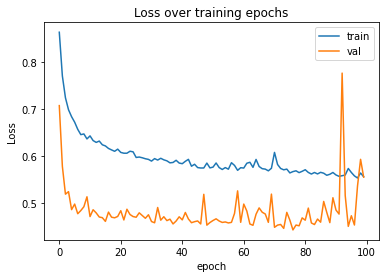

In [26]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.show()

## 検証

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter("ignore")

08_11_0_2


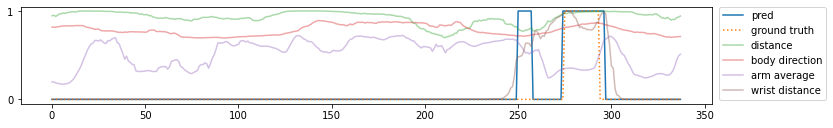

08_34_0_2


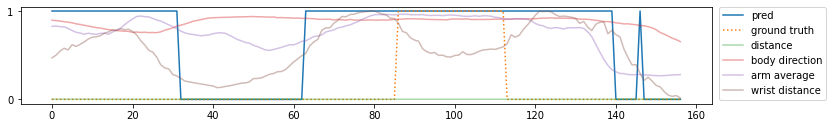

08_04_2_3


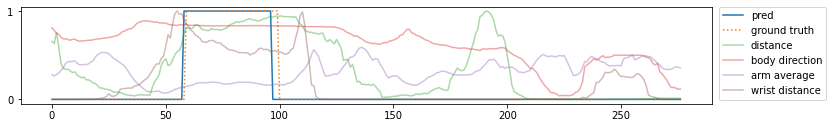

08_15_1_3


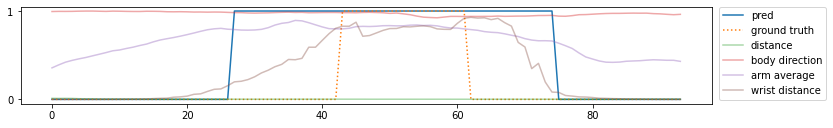

08_40_0_1


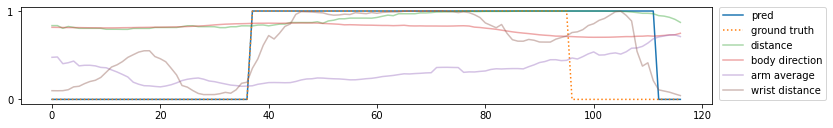

09_07_1_3


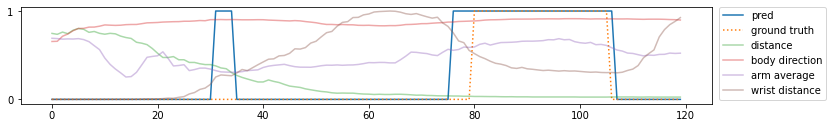

02_01_4_17


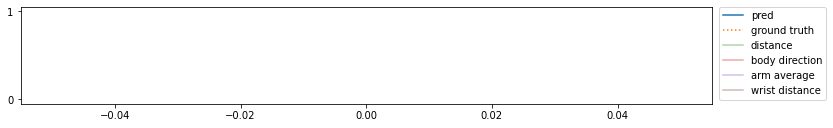

02_02_2_4


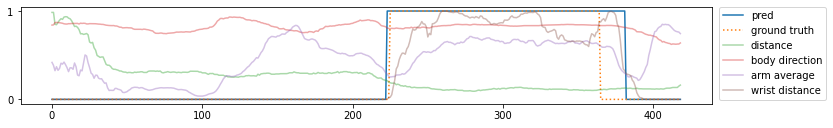

09_03_0_3


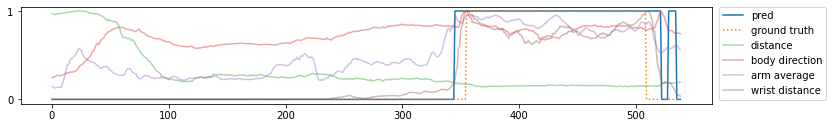

08_14_2_3


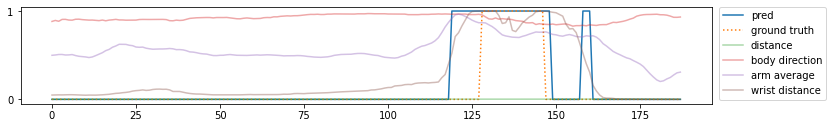

08_12_2_3


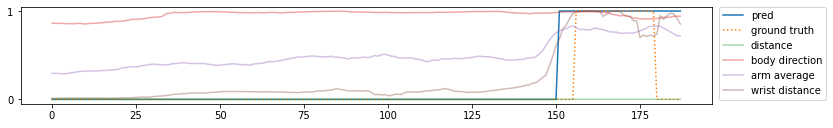

08_33_0_7


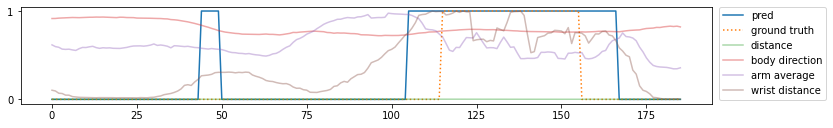

08_38_0_2


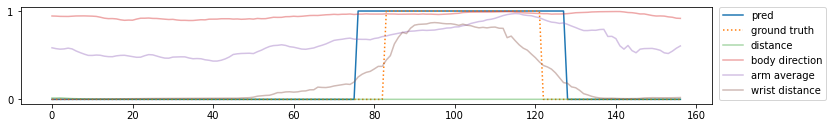

08_21_0_4


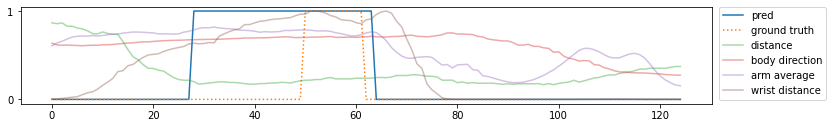

08_09_0_2


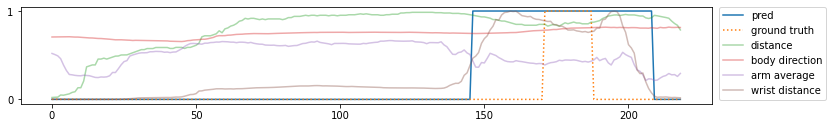

08_03_4_5


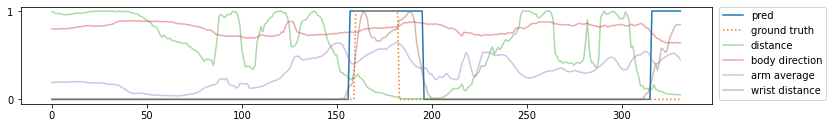

02_05_0_4


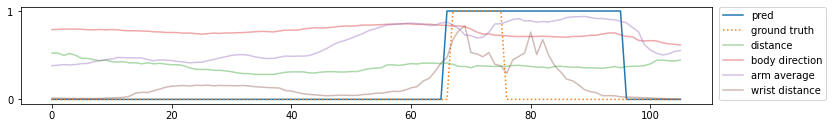

08_05_1_2


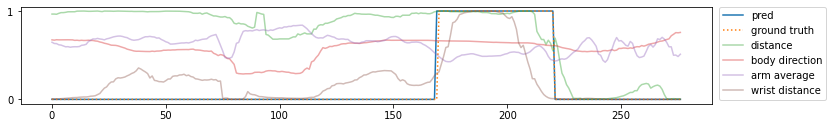

08_02_1_2


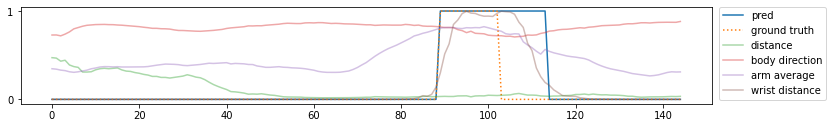

02_13_1_9


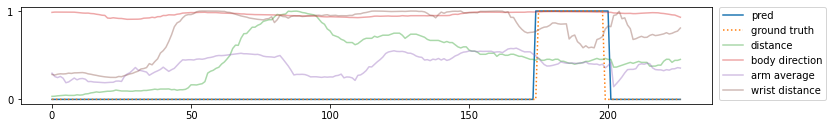

08_25_2_9


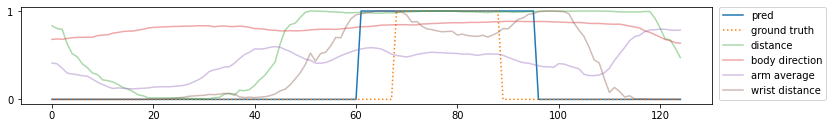

02_02_1_2


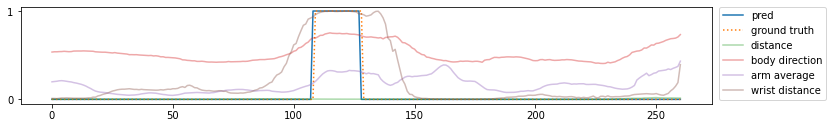

09_08_0_3


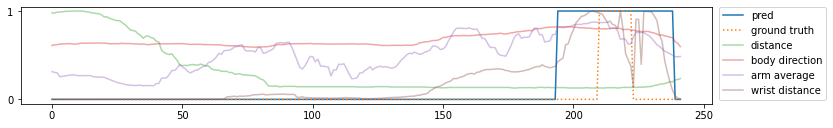

08_18_0_3


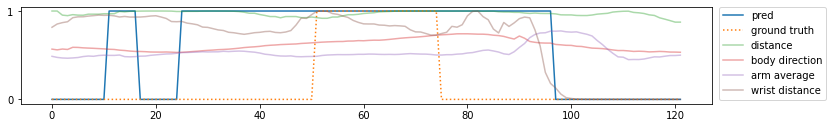

08_35_2_6


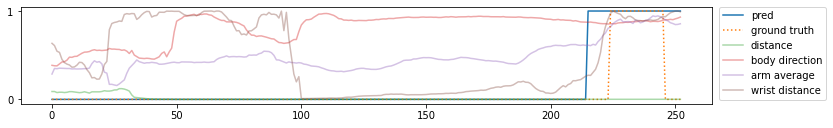

08_41_1_6


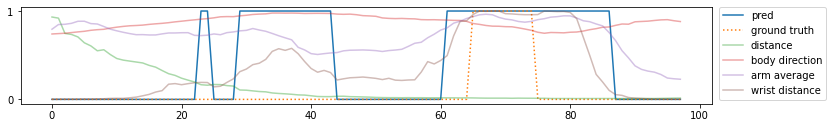

08_07_3_6


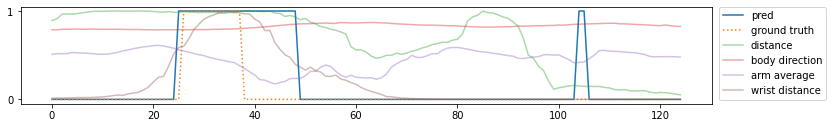

02_11_2_6


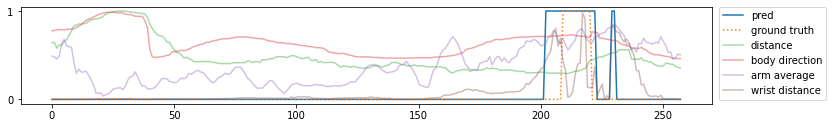

09_09_1_2


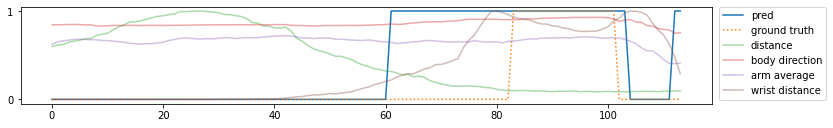

02_15_10_21


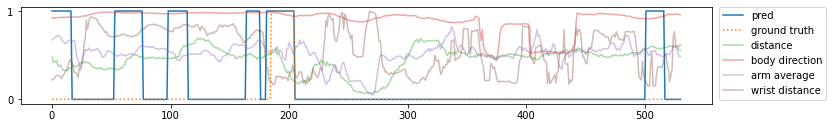

02_09_0_9


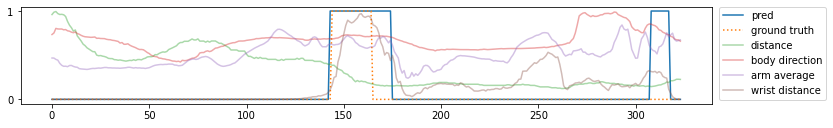

09_05_3_13


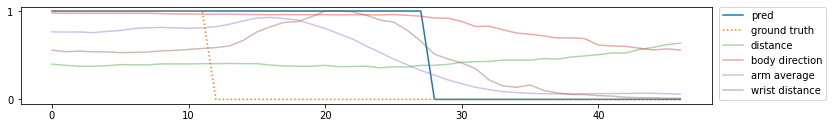

08_32_0_1


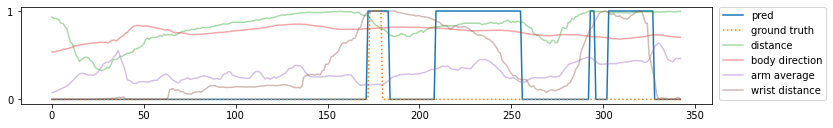

08_29_2_5


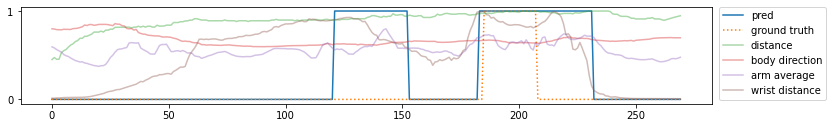

08_19_1_2


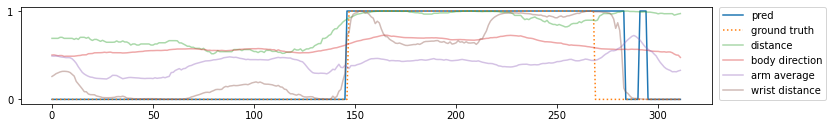

08_13_0_4


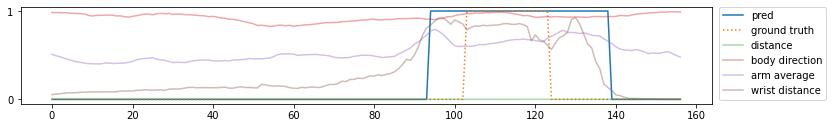

08_06_0_5


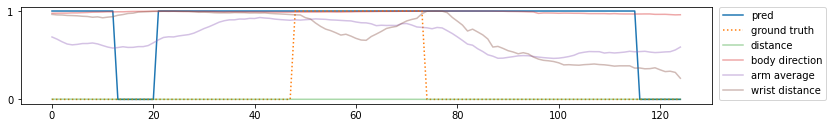

02_22_0_5


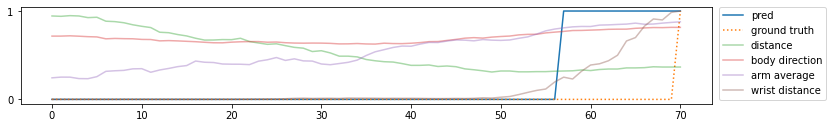

02_03_1_4


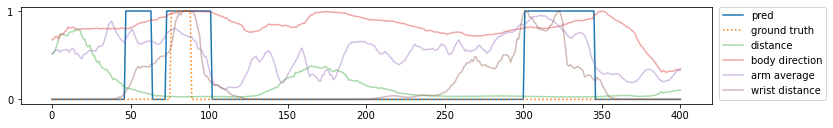

09_02_5_7


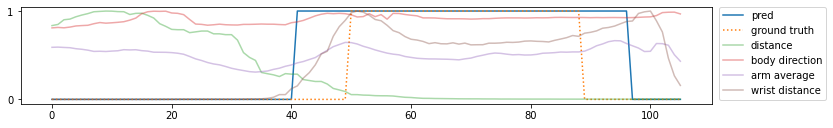

02_20_2_8


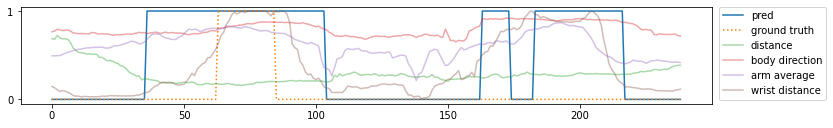

02_18_1_10


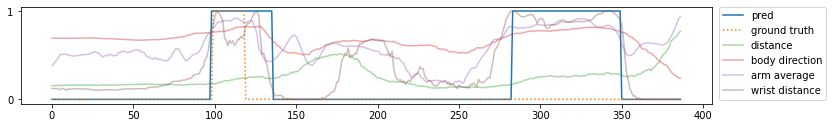

02_19_0_4


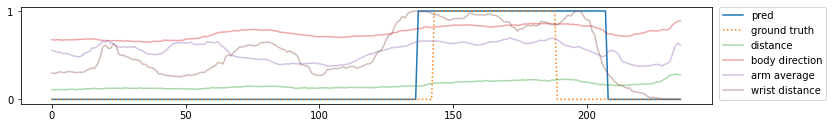

08_23_0_1


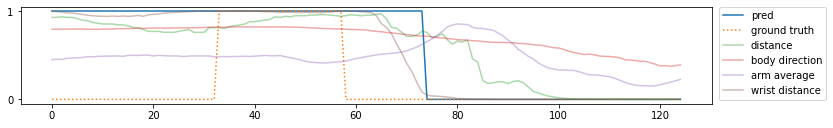

08_01_3_6


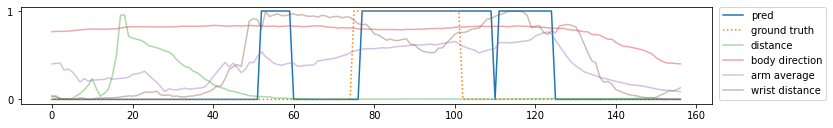

09_01_0_5


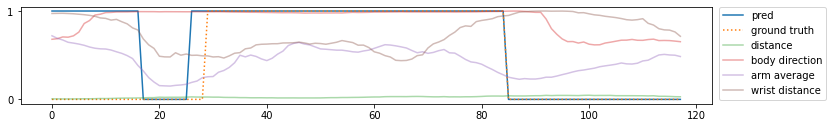

08_24_1_6


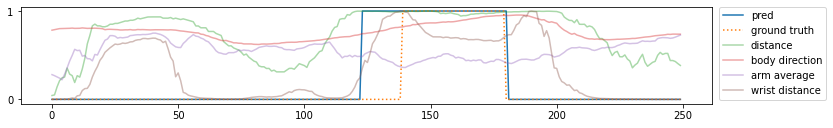

In [28]:
acc_train = []
prcs_train = []
rcl_train = []
f1_train =[]

model.eval()
with torch.no_grad():
    for key in train_keys:
        x_lst = x_dict_fill_nan[key]
        y_lst = y_dict_fill_nan[key]
        
        if 1 not in y_lst:
            continue
        
        x, _ = create_sequence(x_lst, y_lst, **config)
        x = torch.Tensor(x).float().to(device)
        
        if len(x) == 0:
            continue

        pred = model(x)
        pred = pred.max(1)[1]
        pred = pred.cpu().numpy()

        x_lst = x_lst[SEQ_LEN - 1:]
        y_lst = y_lst[SEQ_LEN - 1:]
            
        acc_train.append(accuracy_score(pred, y_lst))
        prcs_train.append(precision_score(pred, y_lst))
        rcl_train.append(recall_score(pred, y_lst))
        f1_train.append(f1_score(pred, y_lst))
            
        print(key)
        plt.figure(figsize=(10, 1.5))
        # plt.rcParams["font.size"] = 20
        # plt.rcParams["font.family"] = 'Times New Roman'
        plt.plot(pred, label='pred')
        plt.plot(y_lst, linestyle=':', label='ground truth')
        for i, x in enumerate(x_lst.T):
            plt.plot(x, alpha=0.4, label=columns[i])
        plt.ylim((-0.05, 1.05))
        plt.yticks([0, 1])
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

        plt.show()

In [29]:
print('accuracy: {:.3f}'.format(np.mean(acc_train)))
print('precision: {:.3f}'.format(np.mean(prcs_train)))
print('recall: {:.3f}'.format(np.mean(rcl_train)))
print('f1_score: {:.3f}'.format(np.mean(f1_train)))

accuracy: 0.813
precision: 0.975
recall: 0.498
f1_score: 0.621


08_16_0_1


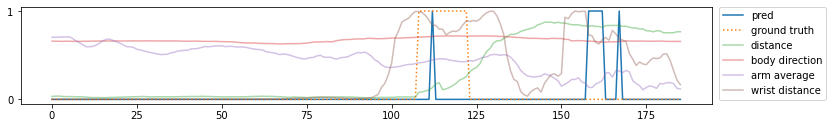

08_30_0_1


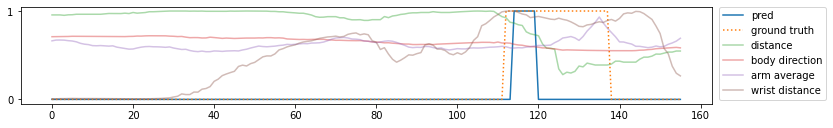

08_36_0_2


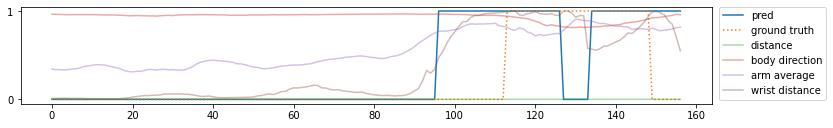

08_08_0_2


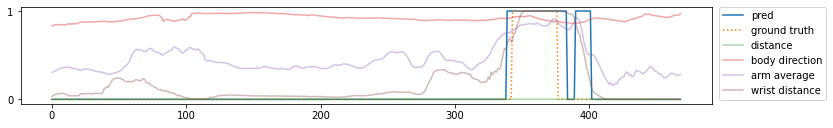

08_17_0_3


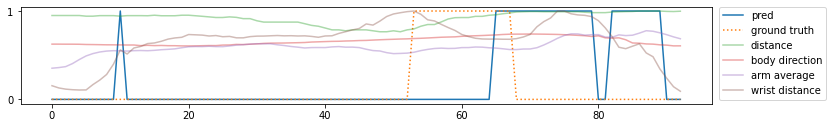

09_06_0_2


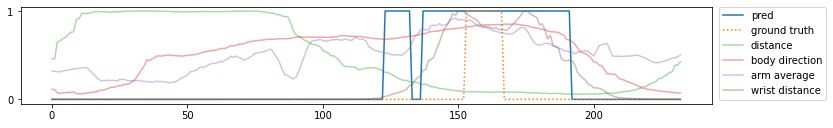

02_23_3_14


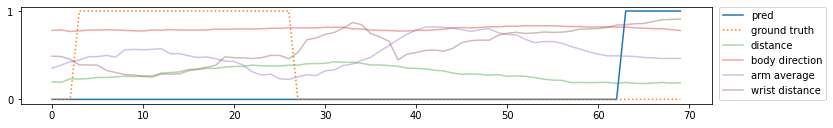

08_20_0_3


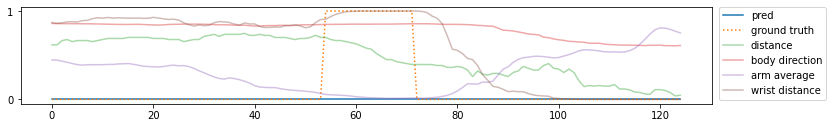

08_39_0_2


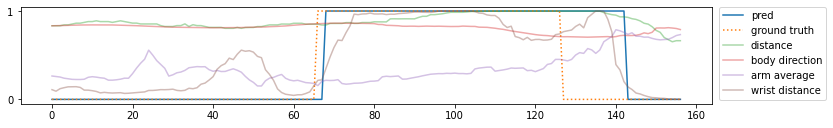

08_26_2_10


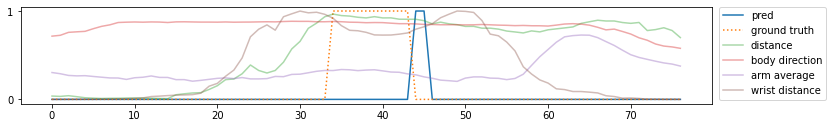

09_04_1_3


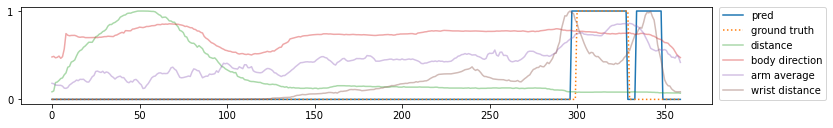

08_27_4_11


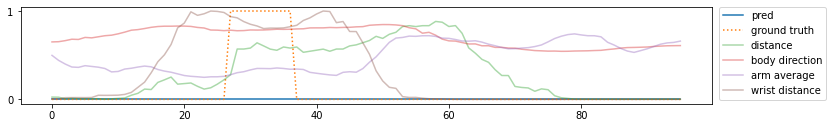

08_10_1_3


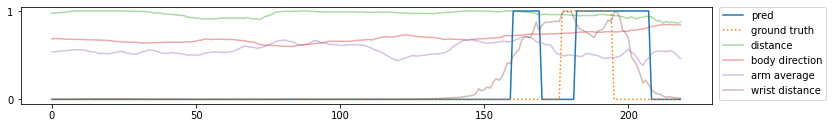

08_37_2_3


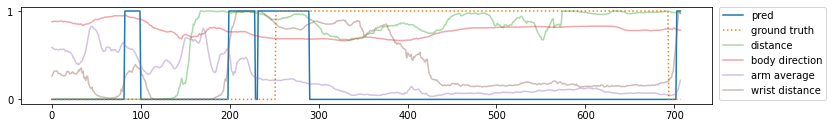

08_31_4_12


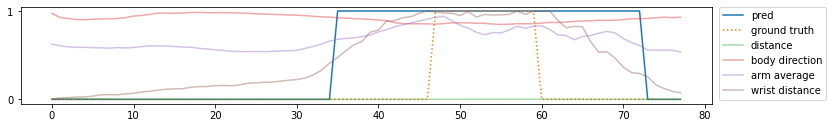

In [30]:
acc_test = []
prcs_test = []
rcl_test = []
f1_test =[]

model.eval()
with torch.no_grad():
    for key in test_keys:
        x_lst = x_dict_fill_nan[key]
        y_lst = y_dict_fill_nan[key]
        
        if 1 not in y_lst:
            continue

        x, _ = create_sequence(x_lst, y_lst, **config)
        x = torch.Tensor(x).float().to(device)

        if len(x) == 0:
            continue
        pred = model(x)
        pred = pred.max(1)[1]
        pred = pred.cpu().numpy()

        x_lst = x_lst[SEQ_LEN - 1:]
        y_lst = y_lst[SEQ_LEN - 1:]
        
        acc_test.append(accuracy_score(pred, y_lst))
        prcs_test.append(precision_score(pred, y_lst))
        rcl_test.append(recall_score(pred, y_lst))
        f1_test.append(f1_score(pred, y_lst))
            
        print(key)
        plt.figure(figsize=(10, 1.5))
        # plt.rcParams["font.size"] = 20
        # plt.rcParams["font.family"] = 'Times New Roman'
        plt.plot(pred, label='pred')
        plt.plot(y_lst, linestyle=':', label='ground truth')
        for i, x in enumerate(x_lst.T):
            plt.plot(x, alpha=0.4, label=columns[i])
        plt.ylim((-0.05, 1.05))
        plt.yticks([0, 1])
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

        plt.show()

In [31]:
print('accuracy: {:.3f}'.format(np.mean(acc_test)))
print('precision: {:.3f}'.format(np.mean(prcs_test)))
print('recall: {:.3f}'.format(np.mean(rcl_test)))
print('f1_score: {:.3f}'.format(np.mean(f1_test)))

accuracy: 0.787
precision: 0.470
recall: 0.338
f1_score: 0.341


In [ ]:
path = f'{common.root}/model/pass_model_lstm.pth'
torch.save(model, path)